### IMPORTAR LIBRERIAS

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import pickle

In [2]:
df_final = pd.read_csv('../data/processed/df_final.csv')
df_final.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_category
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,Media
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,Media
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,Media
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,Media
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,Media
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,Media
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5,Media
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7,Alta
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7,Alta
9,6.7,0.58,0.08,1.8,0.097,15.0,65.0,0.9959,3.28,0.54,9.2,5,Media


In [3]:
#Codificar el target y dividir en train/test dataset
le = LabelEncoder()
X = df_final[['alcohol', 'volatile acidity', 'sulphates', 'citric acid']]
y = le.fit_transform(df_final['quality_category'])

In [4]:
#Entrenamos el modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Aplicamos SMOTE para corregir el desbalance, solo en train
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

### MODELOS SUPERVISADOS

In [6]:
# Definir modelos
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

# Entrenar y evaluar modelos
results = {}

for name, model in models.items():
    model.fit(X_res, y_res)
    y_pred = model.predict(X_test)
    results[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "report": classification_report(y_test, y_pred, target_names=le.classes_)
    }

# Imprimir métricas
for name, result in results.items():
    print(f"Model: {name}")
    print(f"Accuracy: {result['accuracy']:.2f}")
    print("Classification Report:")
    print(result['report'])
    print("-" * 60)

Model: Random Forest
Accuracy: 0.83
Classification Report:
              precision    recall  f1-score   support

        Alta       0.63      0.73      0.68        26
        Baja       0.11      0.22      0.14         9
       Media       0.94      0.87      0.90       201

    accuracy                           0.83       236
   macro avg       0.56      0.61      0.57       236
weighted avg       0.87      0.83      0.85       236

------------------------------------------------------------
Model: Gradient Boosting
Accuracy: 0.75
Classification Report:
              precision    recall  f1-score   support

        Alta       0.52      0.65      0.58        26
        Baja       0.04      0.11      0.06         9
       Media       0.90      0.80      0.85       201

    accuracy                           0.75       236
   macro avg       0.49      0.52      0.49       236
weighted avg       0.83      0.75      0.79       236

-------------------------------------------------------

### MODELO NO SUPERVISADO

In [7]:
# Escalar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_final[['alcohol', 'volatile acidity', 'sulphates', 'citric acid']])

# Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Evaluar
df_final['cluster'] = clusters
print(f"Silhouette Score: {silhouette_score(X_scaled, clusters):.2f}")
print(pd.crosstab(df_final['quality_category'], df_final['cluster']))

Silhouette Score: 0.24
cluster             0    1    2
quality_category               
Alta               11  104   20
Baja               11    1   21
Media             354  233  424


### GRIDSEARCHCV

In [8]:
# Definir pipeline y espacio de búsqueda
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())
])

search_space = [
    {
        'scaler': [StandardScaler(), MinMaxScaler(), None],
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20]
    },
    {
        'scaler': [StandardScaler()],
        'classifier': [SVC()],
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['rbf', 'linear']
    },
    {
        'scaler': [StandardScaler()],
        'classifier': [GradientBoostingClassifier()],
        'classifier__n_estimators': [50, 100],
        'classifier__learning_rate': [0.01, 0.1]
    }
]

# Configurar GridSearchCV
clf = GridSearchCV(
    estimator=pipe,
    param_grid=search_space,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Entrenar GridSearchCV
clf.fit(X_res, y_res)

# Resultados
best_model = clf.best_estimator_
best_params = clf.best_params_
best_score = clf.best_score_

# Imprimir métricas
print(f"Best Model: {best_model}")
print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score:.2f}")

Fitting 5 folds for each of 37 candidates, totalling 185 fits
Best Model: Pipeline(steps=[('scaler', None),
                ('classifier',
                 RandomForestClassifier(max_depth=20, n_estimators=200))])
Best Parameters: {'classifier': RandomForestClassifier(), 'classifier__max_depth': 20, 'classifier__n_estimators': 200, 'scaler': None}
Best Score: 0.92


In [9]:
# Crear un DataFrame con los resultados
metrics_table = pd.DataFrame({
    "Model": list(results.keys()),
    "Accuracy": [result['accuracy'] for result in results.values()]
})

# Añadir el resultado del GridSearchCV
new_row = pd.DataFrame({
    "Model": ["GridSearchCV Best Model"],
    "Accuracy": [best_score]
})

# Concatenar la nueva fila al DataFrame existente
metrics_table = pd.concat([metrics_table, new_row], ignore_index=True)

# Imprimir la tabla
metrics_table

,Model,Accuracy
0,Random Forest,0.830508
1,Gradient Boosting,0.754237
2,SVM,0.262712
3,KNN,0.665254
4,Logistic Regression,0.516949
5,GridSearchCV Best Model,0.918930


In [16]:
import pandas as pd

# Crear un DataFrame con las métricas de los modelos supervisados
supervised_metrics = []
for name, result in results.items():
    supervised_metrics.append({
        'Model': name,
        'Accuracy': result['accuracy'],
        'Precision': result['report'].split()[5],
        'Recall': result['report'].split()[6],
        'F1-Score': result['report'].split()[7]
    })

df_supervised = pd.DataFrame(supervised_metrics)

# Crear un DataFrame con las métricas del modelo no supervisado
unsupervised_metrics = pd.DataFrame({
    'Model': ['KMeans'],
    'Silhouette Score': [silhouette_score(X_scaled, clusters)]
})

# Crear un DataFrame con las métricas del GridSearchCV
gridsearch_metrics = pd.DataFrame({
    'Model': ['GridSearchCV'],
    'Best Score': [best_score]
})

# Combinar todos los DataFrames
df_metrics_key = pd.concat([df_supervised, unsupervised_metrics, gridsearch_metrics], ignore_index=True)

# Mostrar la tabla
df_metrics_key

,Model,Accuracy,Precision,Recall,F1-Score,Silhouette Score,Best Score
0,Random Forest,0.830508,0.63,0.73,0.68,NaN,NaN
1,Gradient Boosting,0.754237,0.52,0.65,0.58,NaN,NaN
2,SVM,0.262712,0.33,0.88,0.48,NaN,NaN
3,KNN,0.665254,0.39,0.77,0.52,NaN,NaN
4,Logistic Regression,0.516949,0.38,0.85,0.52,NaN,NaN
5,KMeans,NaN,NaN,NaN,NaN,0.244666,NaN
6,GridSearchCV,NaN,NaN,NaN,NaN,NaN,0.91893


In [17]:
df_metrics_key.to_csv('df_metrics_key.csv', index=False)

C:\Users\aguir\AppData\Local\Temp\ipykernel_15740\4097506667.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='Accuracy', data=df_supervised, palette=['#8B0000', '#B22222', '#DC143C', '#FF4500', '#FF6347'])


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

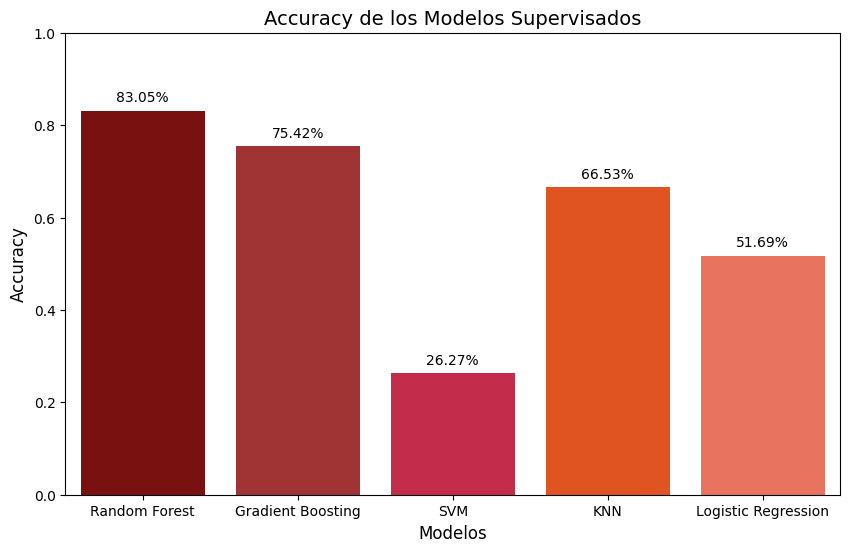

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Crear el gráfico de barras con colores de vino/rojo
ax = sns.barplot(x='Model', y='Accuracy', data=df_supervised, palette=['#8B0000', '#B22222', '#DC143C', '#FF4500', '#FF6347'])

# Añadir los porcentajes de accuracy en las barras
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.02, f'{height:.2%}', ha='center', fontsize=10)

# Configuraciones adicionales
plt.title('Accuracy de los Modelos Supervisados', fontsize=14)
plt.ylim(0, 1)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Modelos', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

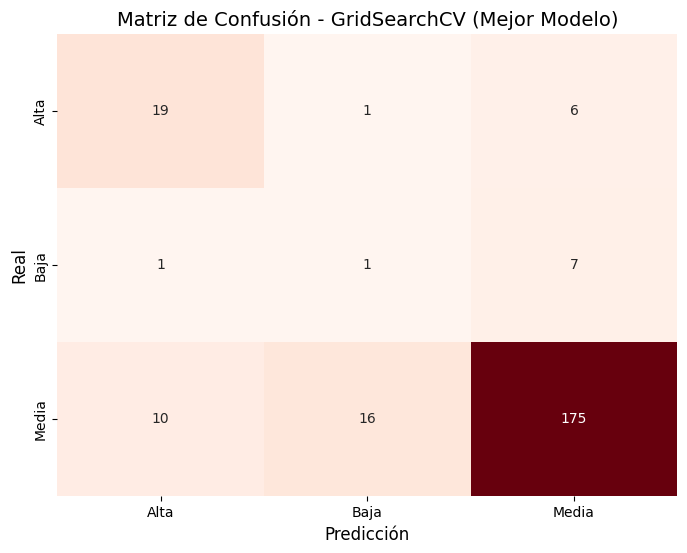

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predecir con el mejor modelo de GridSearchCV
y_pred_gridsearch = best_model.predict(X_test)

# Calcular la matriz de confusión
cm_gridsearch = confusion_matrix(y_test, y_pred_gridsearch)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gridsearch, annot=True, fmt='d', cmap='Reds', cbar=False,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusión - GridSearchCV (Mejor Modelo)', fontsize=14)
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Real', fontsize=12);

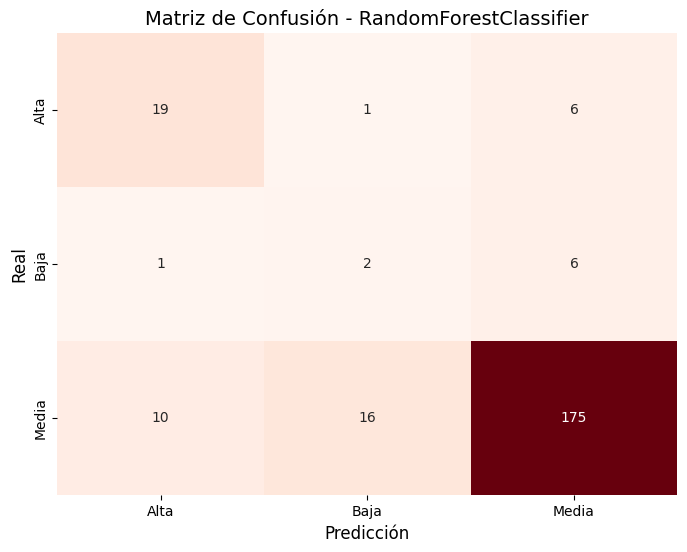

In [13]:
# Predecir con el RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_res, y_res)
y_pred_rf = rf_model.predict(X_test)

# Calcular la matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Reds', cbar=False,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusión - RandomForestClassifier', fontsize=14)
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Real', fontsize=12);

C:\Users\aguir\AppData\Local\Temp\ipykernel_15740\1561408099.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Reds')


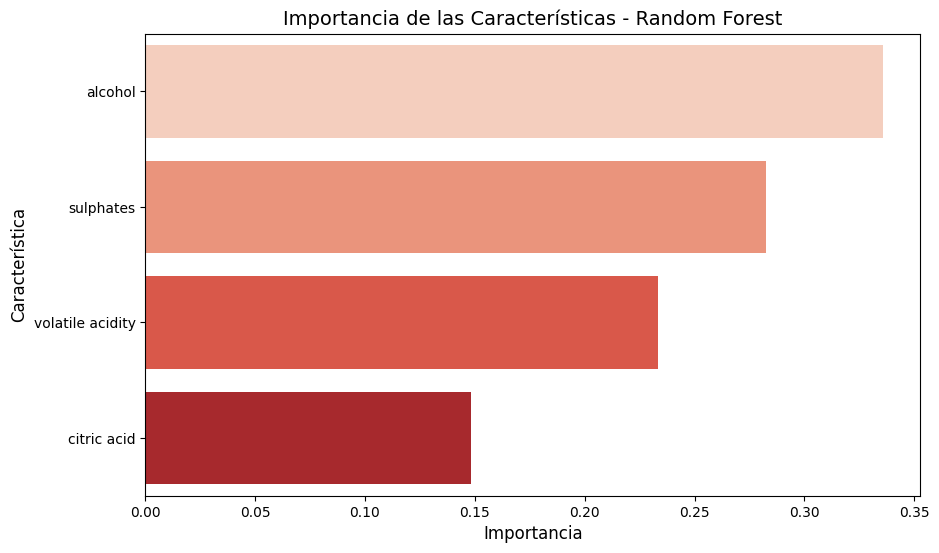

In [14]:
# Obtener la importancia de las características del Random Forest Classifier
feature_importances = rf_model.feature_importances_

# Crear un DataFrame para visualizar las importancias
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Visualizar la importancia de las características
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Reds')
plt.title('Importancia de las Características - Random Forest', fontsize=14)
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Característica', fontsize=12);

Guaradamos modelos:

In [15]:
'''# Guardar modelos supervisados
for name, model in models.items():
    with open(f'{name.lower().replace(" ", "_")}_keyfeatures.pkl', 'wb') as f:
        pickle.dump(model, f)

# Guardar el mejor modelo del GridSearchCV
with open('best_model_gridsearchcv_keyfeatures.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Guardar el modelo KMeans
with open('kmeans_model_keyfeatures.pkl', 'wb') as f:
    pickle.dump(kmeans, f)'''

'# Guardar modelos supervisados\nfor name, model in models.items():\n    with open(f\'{name.lower().replace(" ", "_")}_keyfeatures.pkl\', \'wb\') as f:\n        pickle.dump(model, f)\n\n# Guardar el mejor modelo del GridSearchCV\nwith open(\'best_model_gridsearchcv_keyfeatures.pkl\', \'wb\') as f:\n    pickle.dump(best_model, f)\n\n# Guardar el modelo KMeans\nwith open(\'kmeans_model_keyfeatures.pkl\', \'wb\') as f:\n    pickle.dump(kmeans, f)'